In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
tf.__version__

'2.8.2'

# Load dataset

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
x_train = x_train / 255
x_test = x_test / 255

In [ ]:
x_train = tf.reshape(tf.cast(x_train, tf.float32), [-1, 28 * 28])
x_test = tf.reshape(tf.cast(x_test, tf.float32), [-1, 28 * 28])

In [ ]:
y_train = to_categorical(y_train, 10)

# Create NN class

In [ ]:
class DenseNN(tf.Module):
    def __init__(self, outputs, activate="relu"):
        super().__init__()

        self.outputs = outputs
        self.fl_init = False
        self.activate = activate

    def __call__(self, x):
        if not self.fl_init:
            self.w = tf.random.truncated_normal((x.shape[-1], self.outputs),
                                                stddev=0.1, name="w")
            self.b = tf.zeros([self.outputs], dtype=tf.float32, name="b")

            self.w = tf.Variable(self.w)
            # We can make b untrainable (..., trainable=False)
            self.b = tf.Variable(self.b)

            self.fl_init = True
        
        y = x @ self.w + self.b

        if self.activate == "relu":
            return tf.nn.relu(y)
        elif self.activate == "softmax":
            return tf.nn.softmax(y)


# Create Model class

In [ ]:
class SequentinalModule(tf.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = DenseNN(128)
        self.layer_2 = DenseNN(10, activate="softmax")

    def __call__(self, x):
        return self.layer_2(self.layer_1(x))

"""
Equal to

layer_1 = DenseNN(128)
layer_2 = DenseNN(10, activate="softmax")

def model_predict(x):
    y = layer_1(x)
    y = layer_2(y)
    return y
"""

'\nEqual to\n\nlayer_1 = DenseNN(128)\nlayer_2 = DenseNN(10, activate="softmax")\n\ndef model_predict(x):\n    y = layer_1(x)\n    y = layer_2(y)\n    return y\n'

# Preparing data

## Create model object

In [ ]:
model = SequentinalModule()
model.submodules

(<__main__.DenseNN at 0x7fd3fe3a9890>, <__main__.DenseNN at 0x7fd470347c50>)

## Define loss func

In [ ]:
cross_entropy = lambda y_true, y_pred: tf.reduce_mean(tf.losses.categorical_crossentropy(y_true, y_pred))


## Create optimizer

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.001)


In [ ]:
BATCH_SIZE = 32
EPOCHS = 10
TOTAL = x_train.shape[0]


## Create batches

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

# Train model

In [ ]:
loss = []
for n in range(EPOCHS):
    # Not neccessary, only for prints
    
    for x_batch, y_batch in train_dataset:
        with tf.GradientTape() as tape:
            # inspite of model_pred we use model
            f_loss = cross_entropy(y_batch, model(x_batch))
        
        # Use model
        grads = tape.gradient(f_loss, model.trainable_variables)
        
        # Inspite of ... we use model/ And only one code line
        opt.apply_gradients(zip(grads, model.trainable_variables))
        
        loss.append(f_loss)
    print(loss[n * 32])
    
    

tf.Tensor(2.4967842, shape=(), dtype=float32)
tf.Tensor(1.081599, shape=(), dtype=float32)
tf.Tensor(0.59277713, shape=(), dtype=float32)
tf.Tensor(0.46853283, shape=(), dtype=float32)
tf.Tensor(0.2738968, shape=(), dtype=float32)
tf.Tensor(0.26129532, shape=(), dtype=float32)
tf.Tensor(0.23243222, shape=(), dtype=float32)
tf.Tensor(0.5377968, shape=(), dtype=float32)
tf.Tensor(0.4494236, shape=(), dtype=float32)
tf.Tensor(0.28427416, shape=(), dtype=float32)


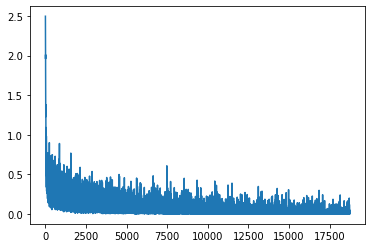

In [ ]:
plt.plot(loss)

# Test

## Calculate accuracy without tf

In [ ]:
y = model(x_test)
y2 = tf.argmax(y, axis=1).numpy()
acc = len(y_test[y_test == y2]) / y_test.shape[0] * 100
print(acc)

97.61


## Calculate accuracy with tf

In [ ]:
acc = tf.metrics.Accuracy()
acc.update_state(y_test, y2)
print(acc.result().numpy() * 100)

97.61000275611877
